Notebook presenting basic Gillespie algorithms for simulating an SIR process in a mean field population.

# Import libraries

In [2]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt


#from numpy.random import seed, rand
from numpy.random import Generator, PCG64

In [3]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x000002AE415FDBF0>


# Mean field SIR

## Functions 

In [37]:
##################################################################################################
def direct_method_SIR_MF(beta_k, mu, T, S, I, R):

    t = 0
    
    #--- Vector to save temporal evolution over time: ---
    X_t = [] 
    X_t.append([t, S, I, R])

    while t < T:
        #--- Infection and recovery probabilites in single time step: ---
        a_inf = S * I * beta_k 
        a_rec = I * mu 
        a_sum = a_inf + a_rec
        
        # Check for a_sum == 0 (no more reactions can happen):
        if np.isclose(a_sum, 0.):
            X_t.append([T, S, I, R])
            break

        #--- Direct event sampling step: ---
        # Draw two uniform random variates (for waiting time and reaction selection):
        u1, u2 = rg.random(2)
        
        # Draw waiting time and increment real time:
        tau = - np.log(1. - u1) / a_sum # rg.random generates u ~ U([0,1)), so use 1 - u to avoid log(0)
        t += tau

        # Select reaction:
        if u2 * a_sum < a_inf:
            S -= 1
            I += 1
            
        else:
            I -= 1
            R += 1
                
        #--- Save current state to X_t: ---
        X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose())
##################################################################################################
##################################################################################################
def first_reaction_method_SIR_MF(beta_k, mu, T, S, I, R):

    t = 0
    
    #--- Vector to save temporal evolution over time: ---
    X_t = [] 
    X_t.append([t, S, I, R])

    while t < T:
        #--- Infection and recovery probabilites in single time step: ---
        propensities = np.array([S * I * beta_k, I * mu])
        
        # Select channels with non-zero propensities to avoid drawing unnecessesary variates and dividing by zero: 
        nonzero_propensities = propensities[propensities > 0.]
        nonzero_channels = np.where(propensities > 0.)[0]
        n_channels = len(nonzero_propensities)
        
        # Check for a_sum == 0 (no more reactions can happen):
        if  n_channels == 0:
            X_t.append([T, S, I, R])
            break

        #--- Direct event sampling step: ---
        # Draw a uniform random variate for each waiting time:
        us = rg.random(n_channels)
        
        # Draw waiting times:
        taus = - np.log(1. - us) / nonzero_propensities # rg.random generates u ~ U([0,1)), so use 1 - u to avoid log(0)
      
        # Select reaction with minimal tau:
        tau_min    = np.min(taus)
        i_selected = nonzero_channels[np.argmin(taus)]
        
        # Update time:
        t += tau_min

        # Select reaction:
        if i_selected == 0:
            S -= 1
            I += 1
            
        else:
            I -= 1
            R += 1
                
        #--- Save current state to X_t: ---
        X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose())
##################################################################################################


## Direct method
One reaction channel for each S individual (infection) and each I individual (recovery).

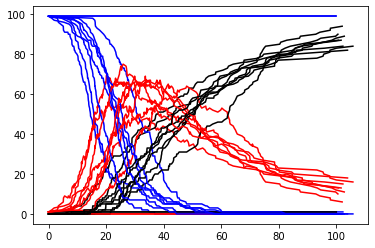

In [38]:

#--- Simulation parameters: ---
beta = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

beta_k = beta * float(k) / float(N) # Effective mean field infection rate

dt = 0.01 # Time step length

Q = 10

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(Q):    
    X_array.append(direct_method_SIR_MF(beta_k, mu, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

## First reaction method

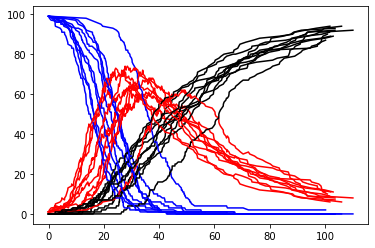

In [40]:

#--- Simulation parameters: ---
beta = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

beta_k = beta * float(k) / float(N) # Effective mean field infection rate

dt = 0.01 # Time step length

Q = 10

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(Q):    
    X_array.append(first_reaction_method_SIR_MF(beta_k, mu, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]